In [158]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d
import stlstuff as sls
import imagestuff as ims

import copy 
import os
import time
from sys import platform
from scipy.interpolate import griddata

#import f90nml

In [159]:
%matplotlib notebook

In [160]:
def get_heights(\
                  nsegments,nx1list,nx2list,ny1list,ny2list,dx,dy,solution,\
                  accumlist):

    # Looping over all the segments
    for isegment in range(0,nsegments):

        # Extract this segment
        nx1=nx1list[isegment]; nx2=nx2list[isegment]; nxsegment = nx2-nx1+1
        ny1=ny1list[isegment]; ny2=ny2list[isegment]; nysegment = ny2-ny1+1
        surf_xseg = np.linspace(0,(nxsegment-1)*dx,nxsegment); 
        surf_yseg = np.linspace(0,(nysegment-1)*dy,nysegment); 
        surf_xseggrid, surf_yseggrid = np.meshgrid(surf_xseg,surf_yseg) # 1st index is y, 2nd is x
        surf_zseggrid = copy.copy(np.flipud(solution[ny1:ny2+1,nx1:nx2+1])) # This flips the y-coordinate

        # Fit a plane to the data and adjust data to start at the origin
        m = ims.polyfit2d(\
                      surf_xseggrid.reshape(nysegment*nxsegment), \
                      surf_yseggrid.reshape(nysegment*nxsegment), \
                      surf_zseggrid.reshape(nysegment*nxsegment), \
                      linear=True,order=1)

        # Get the angles of the plane
        dzdy = m[1]; thetay = np.arctan(dzdy)*180/np.pi; #print 'y:', thetay

        # Get rotation matrix & flatten in one direction
        Roty = ims.myrotation_matrix([1,0,0], -thetay)
        surf_xseggridp, surf_yseggridp, surf_zseggridp = \
            ims.flatten(surf_xseggrid, surf_yseggrid, surf_zseggrid, Roty)

        # Fit a plane to the data and adjust data to start at the origin
        mp = ims.polyfit2d(\
                      surf_xseggridp.reshape(nysegment*nxsegment), \
                      surf_yseggridp.reshape(nysegment*nxsegment), \
                      surf_zseggridp.reshape(nysegment*nxsegment), \
                      linear=True,order=1)

        # Get the angle of the plane in another direction
        dzdx = mp[2]; thetaxp = np.arctan(dzdx)*180/np.pi; #print 'x:', thetaxp

        # Get rotation matrix & flatten in another direction
        Rotxp = ims.myrotation_matrix([0,1,0], thetaxp)
        surf_xseggridpp, surf_yseggridpp, surf_zseggridpp = \
            ims.flatten(surf_xseggridp, surf_yseggridp, surf_zseggridp, Rotxp)


        # Trying out the polyval2d
        surf_zseggrid_theory_long = ims.polyval2d(\
                      surf_xseggrid.reshape(nysegment*nxsegment), \
                      surf_yseggrid.reshape(nysegment*nxsegment), \
                      m)
        surf_zseggrid_theory = surf_zseggrid_theory_long.reshape(nysegment,nxsegment)
        #surf_zseggrid_theory -= z0
        surf_xseggridp_theory, surf_yseggridp_theory, surf_zseggridp_theory = \
            ims.flatten(surf_xseggrid, surf_yseggrid, surf_zseggrid_theory, Roty)
        surf_xseggridpp_theory, surf_yseggridpp_theory, surf_zseggridpp_theory = \
            ims.flatten(surf_xseggridp_theory, surf_yseggridp_theory, surf_zseggridp_theory, Rotxp)

        # Now rotate
        deltay = surf_yseggridpp_theory[0,-1]-surf_yseggridpp_theory[0,0]
        deltax = surf_xseggridpp_theory[0,-1]-surf_xseggridpp_theory[0,0]
        thetazpp = -np.arctan(deltay/deltax)*180/np.pi;
        Rotzpp = ims.myrotation_matrix([0,0,1], thetazpp)
        surf_xseggridppp, surf_yseggridppp, surf_zseggridppp = \
            ims.flatten(surf_xseggridpp, surf_yseggridpp, surf_zseggridpp, Rotzpp)
        surf_xseggridppp_theory, surf_yseggridppp_theory, surf_zseggridppp_theory = \
            ims.flatten(surf_xseggridpp_theory, surf_yseggridpp_theory, surf_zseggridpp_theory, Rotzpp)

        # Now we have to extract an orthogonal subset
        dxsub = dysub = dx
        xsubstart = np.max(surf_xseggridppp_theory[[0,-1],0])+dxsub*2
        xsubstop = np.min(surf_xseggridppp_theory[[0,-1],-1])-dxsub*2
        ysubstart = np.max(surf_yseggridppp_theory[0,[0,-1]])+dysub*2
        ysubstop = np.min(surf_yseggridppp_theory[-1,[0,-1]])-dysub*2
        xsub = np.arange(xsubstart,xsubstop,dxsub)
        ysub = np.arange(ysubstart,ysubstop,dysub)
        sub_xseggrid, sub_yseggrid = np.meshgrid(xsub,ysub) # 1st index is y, 2nd is x
        nsuby, nsubx = np.shape(sub_xseggrid)
        surf_xseggridppp_theory_long = np.reshape(surf_xseggridppp_theory,nysegment*nxsegment)
        surf_yseggridppp_theory_long = np.reshape(surf_yseggridppp_theory,nysegment*nxsegment)
        points = np.vstack((surf_xseggridppp_theory_long,surf_yseggridppp_theory_long)).T # rows are x,y pairs
        values = np.reshape(surf_zseggridppp,nysegment*nxsegment)
        sub_zseggrid_long = griddata(points, values, (sub_xseggrid, sub_yseggrid), method='cubic')
        sub_zseggrid = np.reshape(sub_zseggrid_long,(nsuby, nsubx))

        # Now we get the heights relative to a reference
        zreference = np.median(sub_zseggrid)
        
        # Accumulate the binned data
        if isegment in accumlist:
            zout = zreference

    # Get out
    return zout


In [161]:
# Have to do this in case of different operating systems
if platform == "linux" or platform == "darwin":
    slash = '/'
else: # This is assumed to be Windows
    slash = '\\'
#print(slash)

In [164]:
Iwantsyntheticdata = False
#Iwantsyntheticdata = True

if Iwantsyntheticdata:
    
    # Load a height file (for synthetic data)
    sollast = np.loadtxt("Fri Mar  1 14_36_55 2019"+slash+"surface.txt")
    sollast = sollast - np.mean(sollast)
    Ny, Nx = np.shape(sollast); #print(sollast.shape) #print(Nx,Ny)
    Lx = 30; Ly = 31

    # Getting the x,y grids
    x = np.linspace(0,Lx,Nx); dx = x[1]-x[0]
    y = np.linspace(0,Ly,Ny); dy = y[1]-y[0]
    xgrid,ygrid = np.meshgrid(x,y); #print(xgrid.shape)

else:
    # Load the height file (for real data)
    npzfile = np.load("Case2.1"+slash+"Segmentsretrieved.npz")
    nx1list = npzfile['nx1list']
    nx2list = npzfile['nx2list']
    ny1list = npzfile['ny1list']
    ny2list = npzfile['ny2list']
    solution = npzfile['solution']
    nsegments = len(nx1list)
    accumlist = [5]
    sollast = get_heights(\
                  nsegments,nx1list,nx2list,ny1list,ny2list,dx,dy,solution,\
                  accumlist)


/Users/nesh/Documents/Repositories/IceContinuum with Maggie/imagestuff.py:204: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, _, _, _ = np.linalg.lstsq(G, z)
/Users/nesh/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/nesh/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [134]:
# Plot the surface as a mesh
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xgrid, ygrid, sollast)
ax.set_xlabel('x')
ax.set_ylabel('y')

<IPython.core.display.Javascript object>

Text(0.5,0,'y')

In [135]:
# Fourier transform it
sollast_FT = np.fft.fft2(sollast)
sollast_FTshift = np.fft.fftshift(sollast_FT)

# And get the frequencies
kx = np.fft.fftfreq(Nx,dx)
ky = np.fft.fftfreq(Ny,dy)
kxshift = np.fft.fftshift(kx)
kyshift = np.fft.fftshift(ky)
kxshiftgrid,kyshiftgrid = np.meshgrid(kxshift,kyshift); #print(kxgrid.shape)

<IPython.core.display.Javascript object>


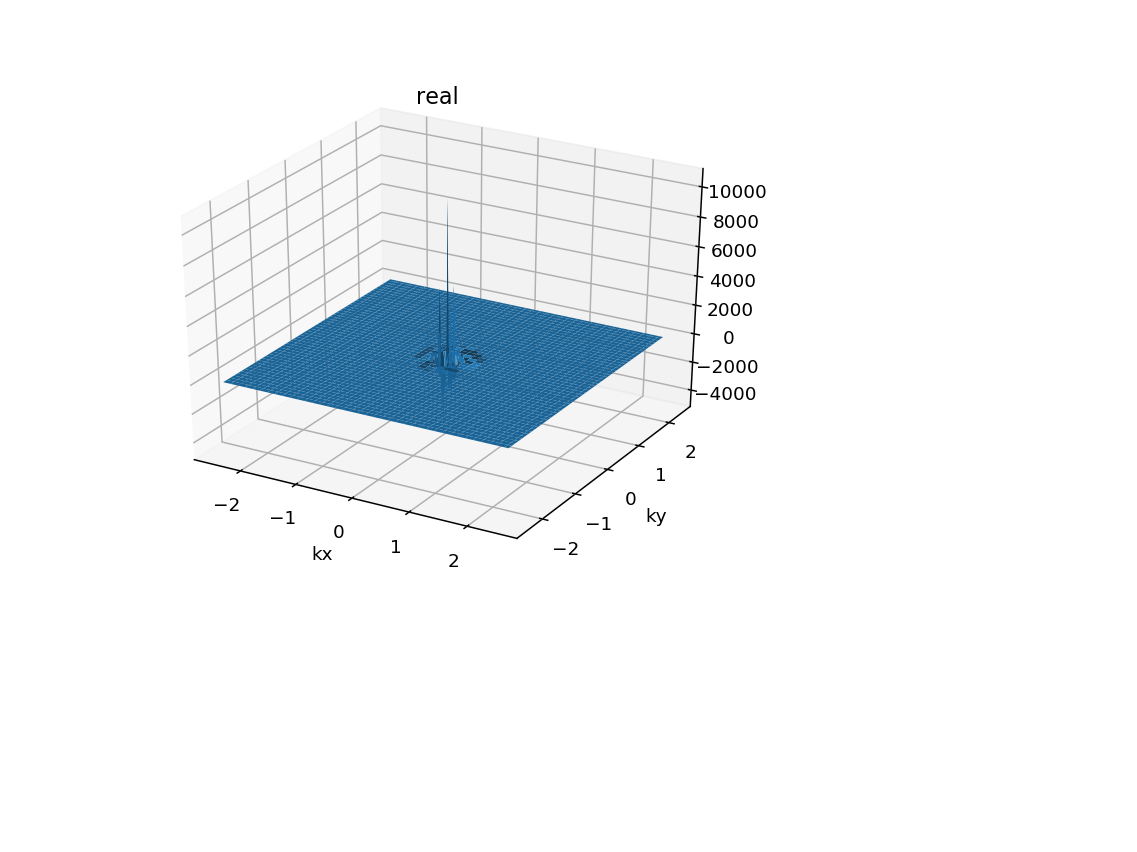

<IPython.core.display.Javascript object>


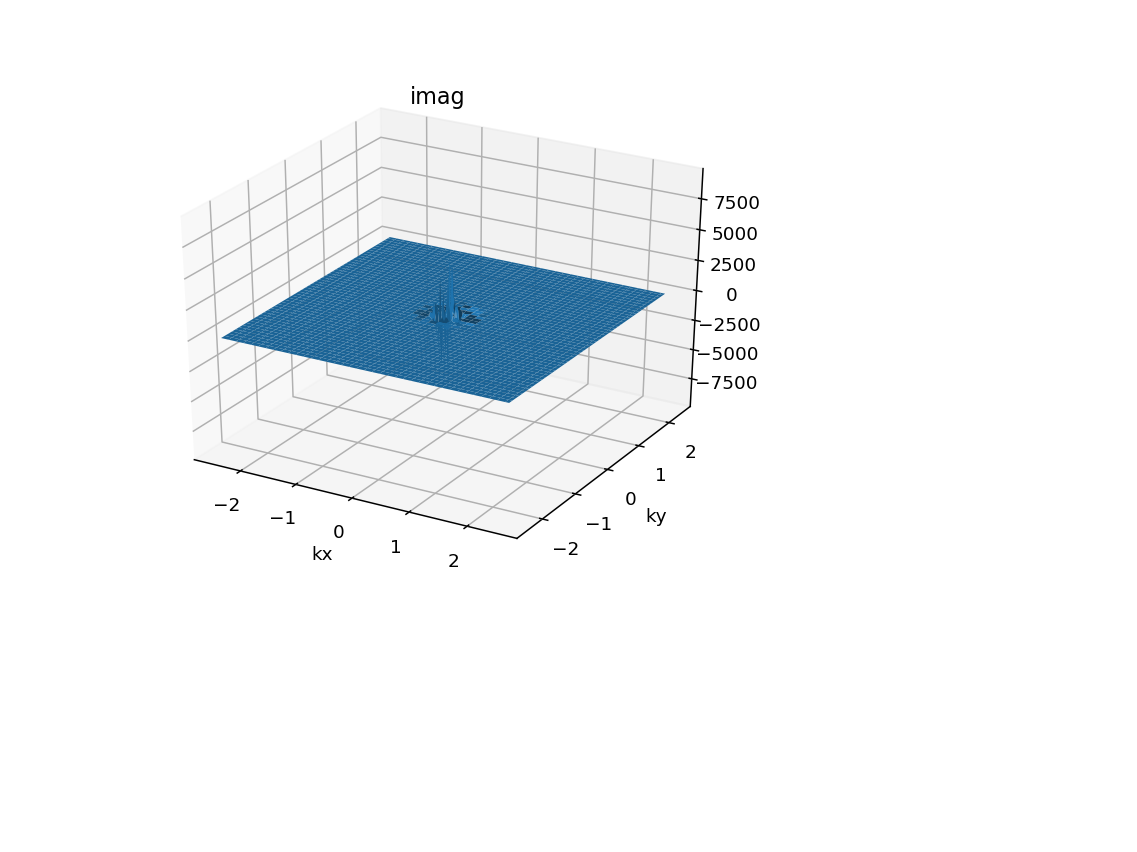

Text(0.5,0.92,'imag')

In [136]:
# Plot real and imaginary parts
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(kxshiftgrid, kyshiftgrid, np.real(sollast_FTshift))
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_title('real')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(kxshiftgrid, kyshiftgrid, np.imag(sollast_FTshift))
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_title('imag')

In [137]:
# Make a copy of the Fourier representation
sollast_FTshift_filtered = sollast_FTshift*1

In [138]:
# Applying a mask
kmax = 0.2
for ix in range(Nx):
    for iy in range(Ny):
        ktest = np.sqrt(kxshiftgrid[iy,ix]**2+kyshiftgrid[iy,ix]**2)
        if(ktest>kmax):
            sollast_FTshift_filtered[iy,ix]=0

<IPython.core.display.Javascript object>


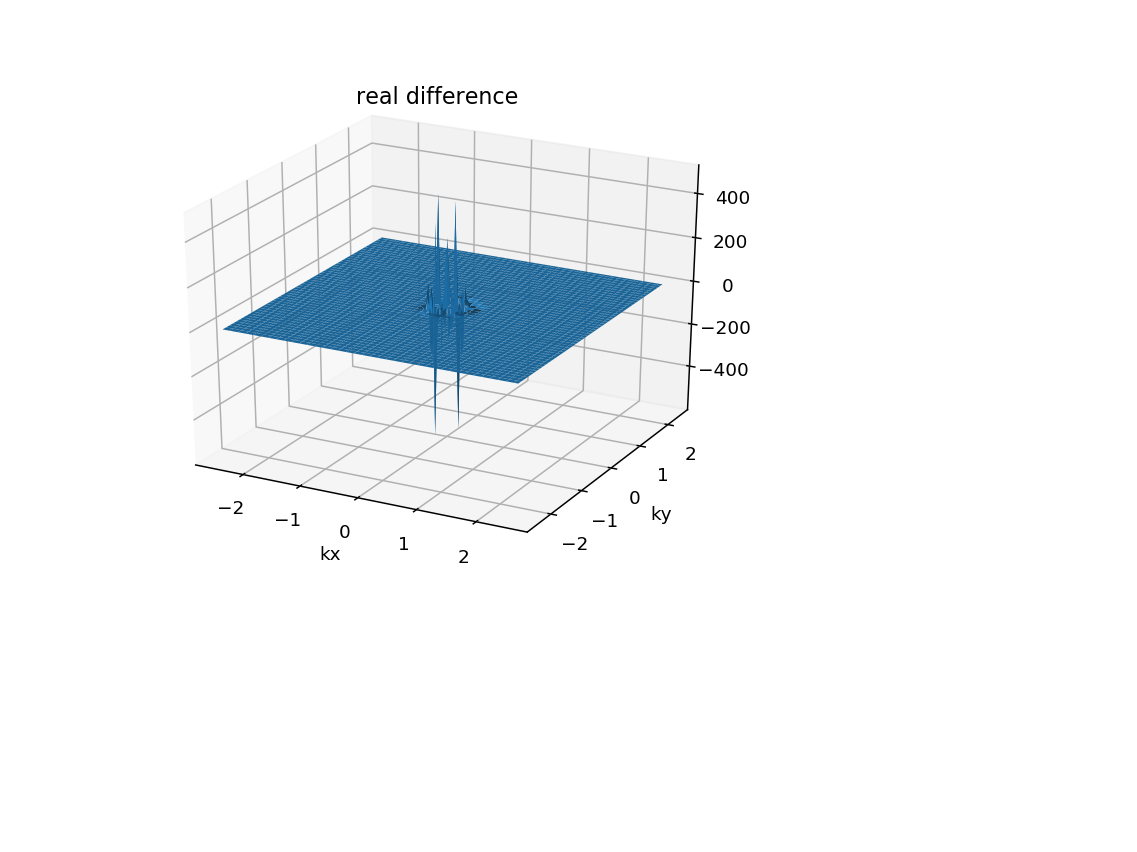

Text(0.5,0.92,'real difference')

In [139]:
# Plot the difference
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(kxshiftgrid, kyshiftgrid, np.real(sollast_FTshift_filtered-sollast_FTshift))
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_title('real difference')

In [140]:
# Un-shift it
sollast_FT_filtered = np.fft.ifftshift(sollast_FTshift_filtered)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


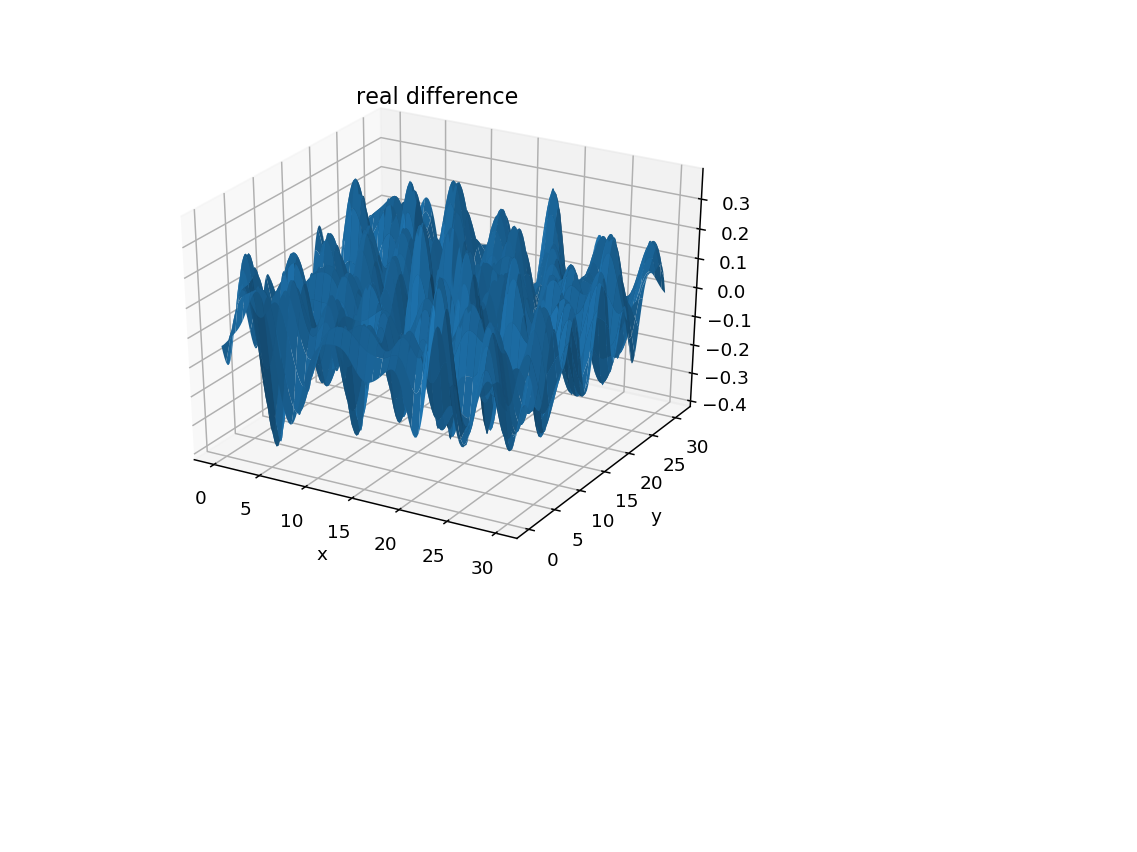

<IPython.core.display.Javascript object>

Text(0.5,0.92,'imag')

In [146]:
# Inverse Fourier transform
sollast_FT_filtered_IFT = np.fft.ifft2(sollast_FT_filtered)

# Plot it
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xgrid, ygrid, np.real(sollast_FT_filtered_IFT))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('real')

# Plot it
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xgrid, ygrid, np.real(sollast_FT_filtered_IFT-sollast))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('real difference')

# Plot it
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xgrid, ygrid, np.imag(sollast_FT_filtered_IFT))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('imag')